### How to run:
The first step is to upload the **training file**. Afterwards, as the code has been written in order. So pleaser run the cells one by one. 
The main parts of code are **preprocessing** and **evaluate** functions that provide appropriate data and run all four models (LR, SVM, RF and GuassianNB) in a loop.<br />
 **Note that for each combination of cleaning approach, there is a code named step.* <br />


The signature of the main functions:<br />
> X , y = preprocessing(df,step) <br />
  >> df : input dataframe <br />
  >> step : <br />
  >>> **0** : means just doing lowercasing <br />
>>> **1** : means doing lowercasing, removing punctuations and  stopwords<br />
>>> **2**: means doing lowercasing, removing punctuations and  stopwords,lemmatization,removing url/html tags<br />
>>> **3** : means doing lowercasing, removing punctuations and  stopwords,lemmatization,removing url/html tags,emojis,and chatwords<br /> 


> evaluate(step)


In [47]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import numpy as np
from string import punctuation

import re
import nltk
import spacy
import string

import statistics

from nltk.stem.porter import PorterStemmer

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Load dataset

In [4]:
#data = pd.read_csv('./data/train_all_tasks.csv')
data = pd.read_csv('/content/train_all_tasks.csv')
df = data.filter(['text', 'label_sexist'])
df.columns = ['text', 'label']
df["text"] = df["text"].astype(str)
df.head(2)

,text,label
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist


### Data pre-processing


In [5]:
# Thanks : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py for Emoticons and
# Thanks : https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt)) for list of chat words

EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
# Chat words removal
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

In [6]:

# Punctuation removal:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

#Stop words removal:
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Lemmatization
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# Emojis Removal
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Emoticons removal
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

# URL and Html tag removal
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    t= url_pattern.sub(r'', text)
    html=re.compile(r'<.*?>') 
    return html.sub(r'',t) #Removing html tags

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [7]:
#cleaning combinations:
    # 0- lowercase
    # 1- lowercase, punctuation, stopwords
    # 2- lowercase, punctuation, stopwords,lemma,,url/tags
    # 3- lowercase, punctuation, stopwords,lemma,,url/tags,emoji,chatwords
    

# combination 0
def clean_text0(text):
    text = text.lower()
    return text

# combination 1
def clean_text1(text):
    
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
  
    return text

# combination 2
def clean_text2(text):
    # Chat words removal
    chat_words_map_dict = {}
    chat_words_list = []
    for line in chat_words_str.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
    #text=stem_words(text)
    text=lemmatize_words(text)
    text= remove_urls(text)
    return text



# combination 3
def clean_text3(text):
    # Chat words removal
    chat_words_map_dict = {}
    chat_words_list = []
    for line in chat_words_str.split("\n"):
        if line != "":
            cw = line.split("=")[0]
            cw_expanded = line.split("=")[1]
            chat_words_list.append(cw)
            chat_words_map_dict[cw] = cw_expanded
    chat_words_list = set(chat_words_list)
    text = text.lower()
    text= remove_punctuation(text)
    text=remove_stopwords(text)
    #text=stem_words(text)
    text=lemmatize_words(text)
    text=remove_urls(text)
    text=remove_emoji(text)
    text=convert_emoticons(text)
    text=chat_words_conversion(text)
    return text


In [8]:

# Finalizing preprocessing combination:

def preprocessing(dff,cleaning_step=0):
    if cleaning_step==0:
        # cleaning step 0
        dff["cleaned_text"] = dff["text"].apply(lambda x: clean_text0(x))
    elif cleaning_step==1:
        # cleaning step 1
        dff["cleaned_text"] = dff["text"].apply(lambda x: clean_text1(x))
    elif cleaning_step==2:
        # cleaning step 2
        dff["cleaned_text"] = dff["text"].apply(lambda x: clean_text2(x))
    elif cleaning_step==3:
        # cleaning step 3
        dff["cleaned_text"] = dff["text"].apply(lambda x: clean_text3(x))

    dff = dff.filter(["cleaned_text", "label"])
    dff.columns = ['text', 'label']
    global Encoder 
    Encoder = LabelEncoder()
    XX = dff['text']
    yy = Encoder.fit_transform(dff['label'])
    return XX,yy


### Training 
Algorithms: **SVM/RandomForest/LogisticRegression and Naive Bayesian** model using stratified k-fold cross-validation:

In [45]:
# Main method that executes training and testing 
def evaluate(step):
  k=5
  skf = model_selection.StratifiedKFold(n_splits=k, shuffle=True, random_state=11)  # 20% for dev set in each fold
  # using TF-IDF vectorizer, uni-gram and bi-gram settings
  Tfidf_vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2)) 
  Tfidf_vect.fit(X)
  lrClassifier = LogisticRegression( multi_class='ovr')# multi-class=ovr -> for binary classification
  svmClassifier=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
  rfClassifier=RandomForestClassifier()
  nbClassifier = GaussianNB()
  models=[lrClassifier,svmClassifier,rfClassifier,nbClassifier]
  for model in models:
    accu_skf = []
    f1_skf = []
    precision_skf = []
    recall_skf = []
    p=[]
    predictions=[]
    actual=[]
    i=1
    for train_index, test_index in skf.split(X, y): 
      X_train_fold, X_test_fold = Tfidf_vect.transform(X[train_index]), Tfidf_vect.transform(X[test_index]) 
      y_train_fold, y_test_fold = y[train_index], y[test_index] 
      if type(model).__name__=='GaussianNB':
        X_train_fold=X_train_fold.toarray()
        X_test_fold=X_test_fold.toarray()
      model.fit(X_train_fold, y_train_fold)
      pred = model.predict(X_test_fold)
      if i==1:
        print('Model: {}    Cleaning combination: {} \n'.format(type(model).__name__,step))
        print(classification_report(y_test_fold,pred,target_names=['non sexist','sexist']))
        cm=confusion_matrix(y_test_fold,pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
      
      i=i+1
      accu_skf.append(metrics.accuracy_score(pred, y_test_fold))
      f1_skf.append(metrics.f1_score(pred, y_test_fold, average = 'macro'))
      precision_skf.append(metrics.precision_score(pred, y_test_fold, average = 'macro'))
      recall_skf.append(metrics.recall_score(pred, y_test_fold, average = 'macro'))
    
    print('Model name: {} \n precision:   {}   recall :{} \n  f1: {} accuracy:{}  \n '.format(type(model).__name__,statistics.mean(precision_skf),statistics.mean(recall_skf), statistics.mean(f1_skf), statistics.mean(accu_skf)))
    print('='*50)




### Cleaning combination 0 

In [10]:

warnings.filterwarnings('ignore')
step=0
X,y=preprocessing(df,0)
evaluate(step)

Cleaning step: 0 

Model name: LogisticRegression 
 precision:   0.6245099118549124   recall :0.8238578374808038 
  f1: 0.6447930274965805 accuracy:0.8094285714285714  
 
Cleaning step: 0 

Model name: SVC 
 precision:   0.6800834863942244   recall :0.8293225324915507 
  f1: 0.7118050086006416 accuracy:0.8313571428571429  
 
Cleaning step: 0 

Model name: RandomForestClassifier 
 precision:   0.6754038459373342   recall :0.8655527678333006 
  f1: 0.7095634690556093 accuracy:0.8359285714285715  
 
Cleaning step: 0 

Model name: GaussianNB 
 precision:   0.538491243578074   recall :0.5283927455739313 
  f1: 0.5022448621770462 accuracy:0.5428571428571428  
 


### cleaning combination 1

In [11]:
warnings.filterwarnings('ignore')
step=1
X,y=preprocessing(df,step)
evaluate(step)


Cleaning step: 1 

Model name: LogisticRegression 
 precision:   0.6375362956112244   recall :0.8278546960325556 
  f1: 0.6618107797183826 accuracy:0.8150714285714286  
 
Cleaning step: 1 

Model name: SVC 
 precision:   0.6832677436712368   recall :0.8319728958795481 
  f1: 0.7154796139248277 accuracy:0.8330000000000001  
 
Cleaning step: 1 

Model name: RandomForestClassifier 
 precision:   0.6786201725938729   recall :0.8623343017257539 
  f1: 0.7129916571260272 accuracy:0.8367142857142857  
 
Cleaning step: 1 

Model name: GaussianNB 
 precision:   0.5408839106312021   recall :0.5312879241779042 
  f1: 0.5195567329904386 accuracy:0.5796428571428571  
 


### Cleaning combination 2

In [12]:
warnings.filterwarnings('ignore')
step=2
X,y=preprocessing(df,step)
evaluate(step)

Cleaning step: 2 

Model name: LogisticRegression 
 precision:   0.6479047970535662   recall :0.8400566897796702 
  f1: 0.6752697975519384 accuracy:0.8209285714285715  
 
Cleaning step: 2 

Model name: SVC 
 precision:   0.6855793302875064   recall :0.845334903865905 
  f1: 0.7193264995928255 accuracy:0.8365  
 
Cleaning step: 2 

Model name: RandomForestClassifier 
 precision:   0.6801129197213233   recall :0.8592835825527888 
  f1: 0.7144430289972706 accuracy:0.8368571428571429  
 
Cleaning step: 2 

Model name: GaussianNB 
 precision:   0.5427071749987027   recall :0.532409122436157 
  f1: 0.5193619836366052 accuracy:0.5766428571428571  
 


### Cleaning combination 3

Model: LogisticRegression    Cleaning combination: 3 

              precision    recall  f1-score   support

  non sexist       0.82      0.99      0.89      2121
      sexist       0.89      0.30      0.45       679

    accuracy                           0.82      2800
   macro avg       0.85      0.65      0.67      2800
weighted avg       0.83      0.82      0.79      2800



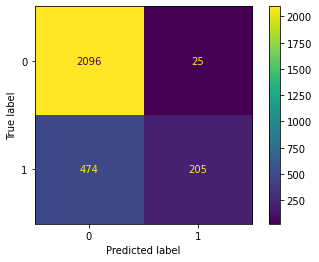

Model name: LogisticRegression 
 precision:   0.6465859951842983   recall :0.8383666186644684 
  f1: 0.6736071810712081 accuracy:0.8201428571428572  
 
Model: SVC    Cleaning combination: 3 

              precision    recall  f1-score   support

  non sexist       0.83      0.98      0.90      2121
      sexist       0.86      0.38      0.53       679

    accuracy                           0.84      2800
   macro avg       0.85      0.68      0.72      2800
weighted avg       0.84      0.84      0.81      2800



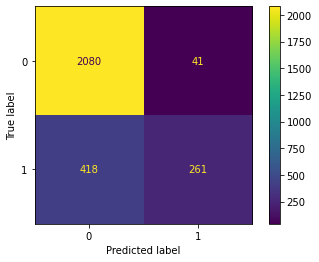

Model name: SVC 
 precision:   0.6855281329696934   recall :0.8455444361275027 
  f1: 0.7193124882660199 accuracy:0.8365714285714286  
 
Model: RandomForestClassifier    Cleaning combination: 3 

              precision    recall  f1-score   support

  non sexist       0.83      0.99      0.90      2121
      sexist       0.91      0.36      0.52       679

    accuracy                           0.84      2800
   macro avg       0.87      0.68      0.71      2800
weighted avg       0.85      0.84      0.81      2800



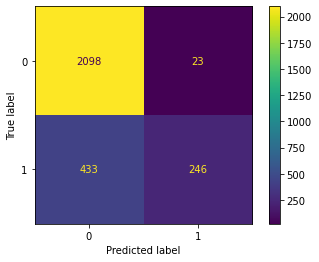

Model name: RandomForestClassifier 
 precision:   0.6783419035078657   recall :0.8595376546723209 
  f1: 0.7124875126585295 accuracy:0.8361428571428572  
 
Model: GaussianNB    Cleaning combination: 3 

              precision    recall  f1-score   support

  non sexist       0.79      0.61      0.69      2121
      sexist       0.29      0.51      0.37       679

    accuracy                           0.58      2800
   macro avg       0.54      0.56      0.53      2800
weighted avg       0.67      0.58      0.61      2800



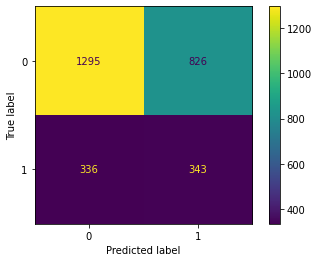

Model name: GaussianNB 
 precision:   0.5443732971704438   recall :0.533640747831818 
  f1: 0.5205910492078343 accuracy:0.5775  
 


In [46]:
warnings.filterwarnings('ignore')
step=3
X,y=preprocessing(df,step)
evaluate(step)